# Tutorial

how to use the longitudinal equilibrium code from the github repository:
        
    https://github.com/lnls-fac/collective_effects

This reference describes the algorithms implemented in the code:

    https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.26.094402

# Import

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from pycolleff.longitudinal_equilibrium import ImpedanceSource, LongitudinalEquilibrium
import pycolleff.rings.sirius as sirius
import pycolleff.impedances as imp
import pycolleff.materials_params as mat_par

# Define Methods

In [2]:
def calculate_longitudinal_equilibrium(ring, impedance_sources, fill=None):
    """
    Calculate longitudinal equilibrium.
    """
    if fill is None:
        fill = np.ones(ring.harm_num) * ring.total_current / ring.harm_num
    longeq = LongitudinalEquilibrium(
        ring=ring, impedance_sources=impedance_sources, fillpattern=fill)
    longeq.feedback_on = False  # main cavity is simulated with effective impedance
    longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb / 2
    longeq.max_mode = 1000*ring.harm_num  # define maximum frequency to consider
    longeq.min_mode0_ratio = 1e-10  # criteria for convergence

    print('Calculating Longitudinal Equilibrium...')
    _ = longeq.calc_longitudinal_equilibrium(
        niter=1000, tol=1e-8, beta=0.1, m=3, print_flag=True)
    return longeq


def print_results(longeq, uniform=True):
    """
    Print and plot the results of longitudinal equilibrium.
    """
    z0, sigmaz = longeq.calc_moments(longeq.zgrid, longeq.distributions)
    if uniform:
        print(f'Bunch 0 centroid: {z0[0]*1e3:.2f} mm')
        print(f'Bunch 0 length: {sigmaz[0]*1e3:.2f} mm')
        plt.figure()
        plt.plot(longeq.zgrid*1e3, longeq.distributions[0])
        plt.xlabel(r'$z$ [mm]')
        plt.ylabel(r'$\lambda(z)$ [1/mm]')
        plt.xlim(-50, 50)
        plt.tight_layout()
        plt.show()
    else:
        fig, (af, ax, ay) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
        fill = longeq.fillpattern.copy()
        idcs = np.arange(fill.size)
        zef = np.isclose(fill, 0)
        af.plot(idcs, fill*1e3, 'o')
        ax.plot(idcs[~zef], z0[~zef]*1e3, 'o')
        ay.plot(idcs[~zef], sigmaz[~zef]*1e3, 'o')
        ax.plot(idcs[zef], z0[zef]*1e3, 'o', color='gray')
        ay.plot(idcs[zef], sigmaz[zef]*1e3, 'o', color='gray')
        af.set_ylabel('Filling Pattern [mA]')
        ax.set_ylabel('Centroid [mm]')
        ay.set_ylabel('Bunch Length [mm]')
        ay.set_xlabel('Bunch Index')
        fig.tight_layout()
        plt.show()

# Create the model of the ring

In [3]:
ring = sirius.create_ring()
ring.en_lost_rad = 870e3
ring.gap_voltage = 3.0e6
ring.total_current = 350e-3
print(ring)

Lattice Version             :   SI.v25.01-s05.02  
Circumference [m]           :       518.387       
Revolution Period [us]      :        1.729        
Revolution Frequency [kHz]  :       578.318       
Energy [GeV]                :        3.000        
U0 [keV]                    :       870.000       
Vgap [MV]                   :        3.000        
Momentum Compaction         :       1.63e-04      
Harmonic Number             :         864         
Current [mA]                :       350.000       
Current per Bunch [mA]      :        0.405        
Synchrotron Tune            :       0.00356       
Tunes x/y                   :    49.078/14.137    
Chromaticities x/y          :     2.500/2.500     
Damping Times x/y/e [ms]    :   16.9/ 22.0 /12.9  
Energy Spread [%]           :        0.0887       
Bunch Length [mm]           :        3.250        



# Active Main Cavity

In [4]:
mcav = ImpedanceSource()
mcav.harm_rf = 1
Q0 = 2e9
Qext = 1.58e5
iQ = 1 / Q0 + 1 / Qext
Q = 1 / iQ
mcav.Q = Q
nmcs = 2
RoverQ = 89
mcav.shunt_impedance = nmcs * RoverQ * mcav.Q
twopi = 2 * np.pi
mcav.ang_freq_rf = twopi * ring.rf_freq
mcav.ang_freq = mcav.harm_rf * mcav.ang_freq_rf
mcav.detune_w = twopi * (-4.9e3)
mcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
mcav.active_passive = ImpedanceSource.ActivePassive.Active

# Define PID transfer function for control loop
def pid_transfer_func(w, wrf, gain=1, kp=1, ki=1, kd=0, delay=0):
    # If you do not want to worry about the details of the voltage gap
    # control system, you can use SIRIUS parameters in this function.
    phase = wrf * delay
    exp_delay = np.exp(-1j * delay * w)
    exp_phase = np.exp(1j * phase)    
    eps = 1e-16
    pid_ctrl = kp + ki / 1j / (w - wrf + eps) + kd * 1j * (w - wrf)
    transfer = gain * pid_ctrl * exp_delay * exp_phase
    return transfer

delay = 1.9e-6
ki = 0.01
kp = 2.96e-6
kd = 0
mcav.loop_ctrl_ang_freq = twopi * ring.rf_freq
mcav.loop_ctrl_transfer = partial(
    pid_transfer_func, kp=kp, ki=ki, delay=delay)
print(mcav)

calc_method         : ImpedanceDFT  
active_passive      : Active  
ang_freq_rf         : 3139.50  [Mrad/s]
ang_freq            : 3139.47  [Mrad/s]
shunt_impedance     : 28.12  [MOhm]
Q                   : 1.58e+05  
RoverQ              : 178.00  [Ohm]
harm_rf             : 1.00  
detune_angle        : -1.26  [rad]
detune_freq         : -4.90  [kHz]
detune_w            : -30787.61  [rad/s]
alpha               : 9935.81  [rad/s]
ang_freq_bar        : 3139.47  [Mrad/s]



In [5]:
longeq = calculate_longitudinal_equilibrium(ring, [mcav])

Calculating Longitudinal Equilibrium...
Iter.: 001, Dist. Diff.: 7.957e-08 (bucket 000), E.T.: 0.270s
--------------------
Iter.: 002, Dist. Diff.: 6.500e-12 (bucket 000), E.T.: 0.284s
--------------------
distribution ok!


Bunch 0 centroid: -0.01 mm
Bunch 0 length: 2.57 mm


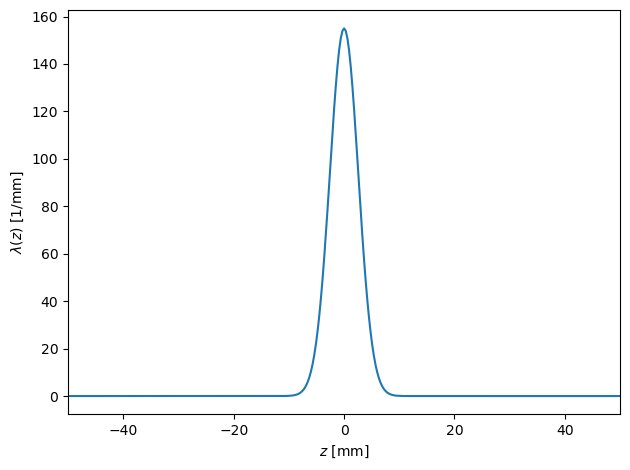

In [6]:
print_results(longeq)

# Passive Hamonic Cavity

In [7]:
hcav = ImpedanceSource()
hcav.harm_rf = 3
hcav.Q = 4e8
RoverQ = 87.5
hcav.shunt_impedance = RoverQ * hcav.Q
twopi = 2 * np.pi
hcav.ang_freq_rf = twopi * ring.rf_freq
hcav.ang_freq = hcav.harm_rf * hcav.ang_freq_rf
hcav.detune_w = twopi * 45e3
hcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
hcav.active_passive = ImpedanceSource.ActivePassive.Passive
print(hcav)

calc_method         : ImpedanceDFT  
active_passive      : Passive  
ang_freq_rf         : 3139.50  [Mrad/s]
ang_freq            : 9418.78  [Mrad/s]
shunt_impedance     : 35000.00  [MOhm]
Q                   : 4.00e+08  
RoverQ              : 87.50  [Ohm]
harm_rf             : 3.00  
detune_angle        : 1.57  [rad]
detune_freq         : 45.00  [kHz]
detune_w            : 282743.34  [rad/s]
alpha               : 11.77  [rad/s]
ang_freq_bar        : 9418.78  [Mrad/s]



In [8]:
longeq = calculate_longitudinal_equilibrium(ring, [hcav, ])

Calculating Longitudinal Equilibrium...
Iter.: 001, Dist. Diff.: 1.770e+00 (bucket 001), E.T.: 0.217s
--------------------
Iter.: 002, Dist. Diff.: 1.743e+00 (bucket 001), E.T.: 0.224s
--------------------
Iter.: 003, Dist. Diff.: 1.634e+00 (bucket 313), E.T.: 0.235s
--------------------
Iter.: 004, Dist. Diff.: 1.323e+00 (bucket 313), E.T.: 0.233s
--------------------
Iter.: 005, Dist. Diff.: 1.321e+00 (bucket 313), E.T.: 0.234s
--------------------
Iter.: 006, Dist. Diff.: 1.296e+00 (bucket 313), E.T.: 0.233s
--------------------
Iter.: 007, Dist. Diff.: 1.219e+00 (bucket 029), E.T.: 0.264s
--------------------
Iter.: 008, Dist. Diff.: 1.118e+00 (bucket 135), E.T.: 0.233s
--------------------
Iter.: 009, Dist. Diff.: 1.158e+00 (bucket 135), E.T.: 0.262s
--------------------
Iter.: 010, Dist. Diff.: 1.160e+00 (bucket 135), E.T.: 0.232s
--------------------
Iter.: 011, Dist. Diff.: 9.932e-01 (bucket 084), E.T.: 0.237s
--------------------
Iter.: 012, Dist. Diff.: 6.049e-01 (bucket 135)

Bunch 0 centroid: -0.23 mm
Bunch 0 length: 11.86 mm


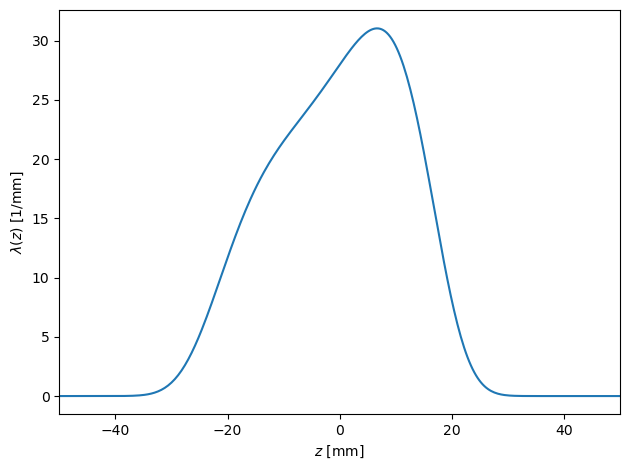

In [9]:
print_results(longeq)

# Broadband Resonators

In [10]:
# These 2 BBRs have numerical problems for Wake (space-domain) method
# No problem for Impedance (frequency-domain) method
frs =    [716.2, 206.9]
qs =     [0.7, 1.3]
shunts = [30.0,   6.5]

frs +=    [138.4, 79.6, 57.3, 35.0, 17.8, 17.5,  11.9,   9.2,   0.888,   0.176,]
qs +=     [  4.0,  1.0,  4.5,  3.0,  1.0, 24.0,  24.0, 100.0, 261.0, 263.0,]
shunts += [  2.0,  2.0,  2.5,  2.5,  1.7,  3.0,   4.0,  20.0,   7.0,   6.0,]

frs = np.array(frs)*1e9  # GHz -> Hz
qs = np.array(qs)
shunts = np.array(shunts)*1e3  # kOhm -> Ohms

freq_rf = ring.rf_freq
bbrs = []
for res_freq, shunt, qfactor in zip(frs, shunts, qs):
    bbr = ImpedanceSource()
    bbr.Q = qfactor
    bbr.shunt_impedance = shunt
    bbr.harm_rf = 1
    bbr.ang_freq_rf = 2*np.pi*freq_rf
    bbr.ang_freq = 2*np.pi*res_freq

    # Methods: Impedance or Wake
    bbr.calc_method = ImpedanceSource.Methods.ImpedanceDFT
    # harm_cav.calc_method = ImpedanceSource.Methods.Wake

    # Device type: Active of Passive
    bbr.active_passive = ImpedanceSource.ActivePassive.Passive    
    bbrs.append(bbr)

In [11]:
longeq = calculate_longitudinal_equilibrium(ring, bbrs)

Calculating Longitudinal Equilibrium...
Iter.: 001, Dist. Diff.: 1.058e-01 (bucket 000), E.T.: 0.352s
--------------------
Iter.: 002, Dist. Diff.: 3.884e-02 (bucket 000), E.T.: 0.365s
--------------------
Iter.: 003, Dist. Diff.: 1.269e-02 (bucket 000), E.T.: 0.376s
--------------------
Iter.: 004, Dist. Diff.: 3.362e-03 (bucket 000), E.T.: 0.382s
--------------------
Iter.: 005, Dist. Diff.: 2.717e-03 (bucket 000), E.T.: 0.375s
--------------------
Iter.: 006, Dist. Diff.: 1.140e-03 (bucket 000), E.T.: 0.396s
--------------------
Iter.: 007, Dist. Diff.: 9.362e-04 (bucket 000), E.T.: 0.375s
--------------------
Iter.: 008, Dist. Diff.: 5.875e-04 (bucket 000), E.T.: 0.376s
--------------------
Iter.: 009, Dist. Diff.: 3.116e-04 (bucket 000), E.T.: 0.374s
--------------------
Iter.: 010, Dist. Diff.: 2.652e-04 (bucket 000), E.T.: 0.373s
--------------------
Iter.: 011, Dist. Diff.: 7.540e-05 (bucket 000), E.T.: 0.376s
--------------------
Iter.: 012, Dist. Diff.: 6.601e-05 (bucket 000)

Bunch 0 centroid: -0.60 mm
Bunch 0 length: 3.08 mm


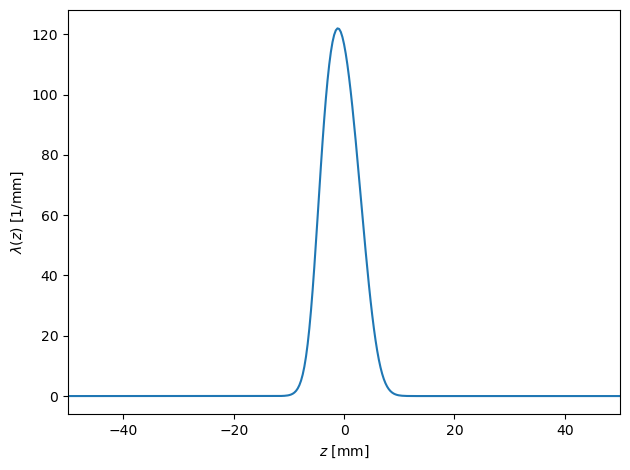

In [12]:
print_results(longeq)

# Generic Impedance Sources

Any impedance table can be used for calculation of the equilibrium.

Here, we calculate the multilayer resistive wall impedance of a round chamber to use as example of a generic impedance.

## Calculate Multilayer Resistive Wall Impedance

In [13]:
cu_cond = mat_par.cu_cond
cu_rel_time = mat_par.cu_rel_time
neg_cond = mat_par.neg_cond
neg_rel_time = mat_par.neg_rel_time
neg_thick = mat_par.neg_thick
ndfe_cond = mat_par.ndfe_cond
ndfe_mur = mat_par.ndfe_mur

energy = 3e9  # [eV]
length = 500  # [m] ~ ring size not considering IDs and injection

epb = np.array([1, 1, 1, 1, 1])
mub = np.array([1, 1, 1, 1, ndfe_mur])
ange = np.array([0, 0, 0, 0, 0])
angm = np.array([0, 0, 0, 0, 0])
sigmadc = np.array([0, neg_cond, cu_cond, 0, ndfe_cond])
tau = np.array([0, neg_rel_time, cu_rel_time, 0, 0])

radius = 12e-3 + np.array([-neg_thick, 0, 1e-3, 3e-3])

ang_freq = imp.get_default_reswall_w(radius=radius[0], energy=energy)

epr, mur = imp.prepare_inputs_epr_mur(
    ang_freq, epb, mub, ange, angm, sigmadc, tau)

Zll, Zdx, Zdy = imp.multilayer_round_chamber(
    ang_freq,
    length,
    energy,
    epr,
    mur,
    radius,
    precision=70,
    wmax_arb_prec=1e12,
    arb_prec_incl_long=False,
    print_progress=True,
)

Zll, ang_freq = imp.get_impedance_for_negative_w(
    Zll, ang_freq, impedance_type='ll'
)

0000/0302 -> freq =        0.1  (ET: 0.06 s)
0001/0302 -> freq =       0.11  (ET: 0.03 s)
0002/0302 -> freq =       0.12  (ET: 0.03 s)
0003/0302 -> freq =       0.13  (ET: 0.03 s)
0004/0302 -> freq =       0.15  (ET: 0.03 s)
0005/0302 -> freq =       0.16  (ET: 0.03 s)
0006/0302 -> freq =       0.17  (ET: 0.03 s)
0007/0302 -> freq =       0.19  (ET: 0.03 s)
0008/0302 -> freq =       0.21  (ET: 0.03 s)
0009/0302 -> freq =       0.23  (ET: 0.03 s)
0010/0302 -> freq =       0.25  (ET: 0.03 s)
0011/0302 -> freq =       0.28  (ET: 0.03 s)
0012/0302 -> freq =       0.31  (ET: 0.03 s)
0013/0302 -> freq =       0.34  (ET: 0.03 s)
0014/0302 -> freq =       0.37  (ET: 0.03 s)
0015/0302 -> freq =        0.4  (ET: 0.03 s)
0016/0302 -> freq =       0.44  (ET: 0.03 s)
0017/0302 -> freq =       0.49  (ET: 0.03 s)
0018/0302 -> freq =       0.53  (ET: 0.03 s)
0019/0302 -> freq =       0.59  (ET: 0.03 s)
0020/0302 -> freq =       0.64  (ET: 0.03 s)
0021/0302 -> freq =       0.71  (ET: 0.03 s)
0022/0302 

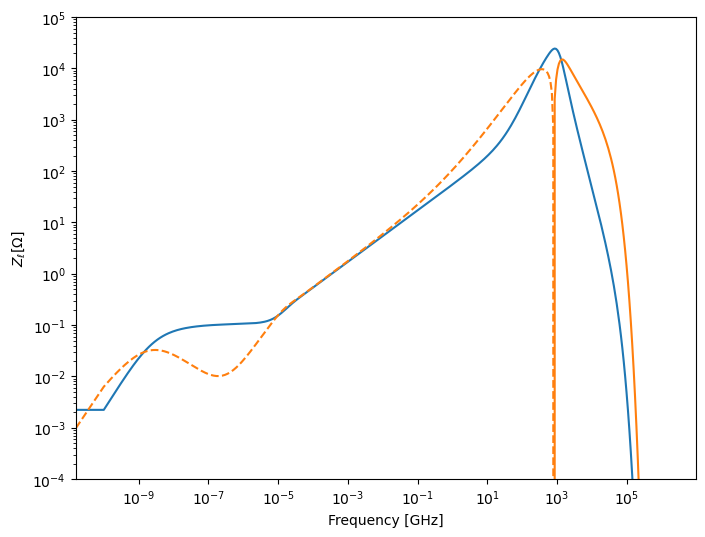

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

freq = ang_freq/2/np.pi * 1e-9  # [GHz]

ax.plot(freq, Zll.real)
ax.plot(freq, Zll.imag)
ax.plot(freq, -Zll.imag, '--', color='C1')

ax.set_ylabel(r'$Z_\ell [\Omega]$')
ax.set_xlabel('Frequency [GHz]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4, 1e5)
plt.show()

## Calculate Equilibrium

In [15]:
generic = ImpedanceSource()
generic.zl_table = Zll
generic.ang_freq_table = ang_freq

# Methods: Impedance or Wake
generic.calc_method = ImpedanceSource.Methods.ImpedanceDFT

# Device type: Active of Passive
generic.active_passive = ImpedanceSource.ActivePassive.Passive

In [16]:
longeq = calculate_longitudinal_equilibrium(ring, [generic, ])

Calculating Longitudinal Equilibrium...
Iter.: 001, Dist. Diff.: 1.062e-02 (bucket 000), E.T.: 0.206s
--------------------
Iter.: 002, Dist. Diff.: 1.300e-03 (bucket 000), E.T.: 0.213s
--------------------
Iter.: 003, Dist. Diff.: 9.740e-04 (bucket 000), E.T.: 0.224s
--------------------
Iter.: 004, Dist. Diff.: 1.112e-04 (bucket 000), E.T.: 0.221s
--------------------
Iter.: 005, Dist. Diff.: 9.796e-05 (bucket 000), E.T.: 0.224s
--------------------
Iter.: 006, Dist. Diff.: 2.161e-05 (bucket 000), E.T.: 0.221s
--------------------
Iter.: 007, Dist. Diff.: 1.447e-05 (bucket 000), E.T.: 0.224s
--------------------
Iter.: 008, Dist. Diff.: 1.174e-05 (bucket 000), E.T.: 0.222s
--------------------
Iter.: 009, Dist. Diff.: 7.567e-06 (bucket 000), E.T.: 0.227s
--------------------
Iter.: 010, Dist. Diff.: 3.251e-06 (bucket 000), E.T.: 0.222s
--------------------
Iter.: 011, Dist. Diff.: 2.877e-06 (bucket 000), E.T.: 0.230s
--------------------
Iter.: 012, Dist. Diff.: 3.331e-07 (bucket 000)

Bunch 0 centroid: -0.14 mm
Bunch 0 length: 2.77 mm


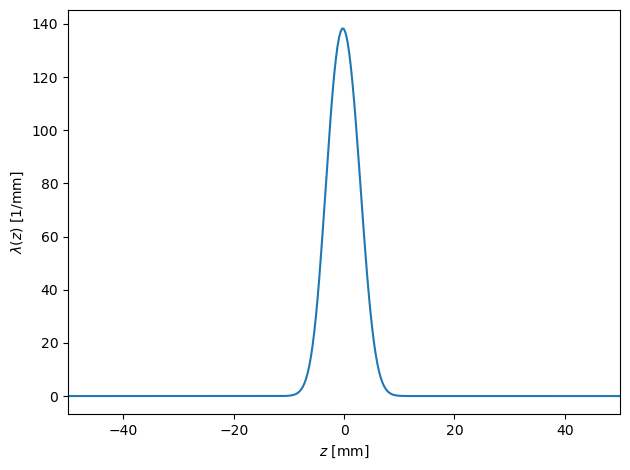

In [17]:
print_results(longeq)

# Several Impedance Sources

In [18]:
longeq = calculate_longitudinal_equilibrium(ring, [mcav, hcav, generic])

Calculating Longitudinal Equilibrium...
Iter.: 001, Dist. Diff.: 1.780e+00 (bucket 002), E.T.: 0.274s
--------------------
Iter.: 002, Dist. Diff.: 1.750e+00 (bucket 014), E.T.: 0.283s
--------------------
Iter.: 003, Dist. Diff.: 1.649e+00 (bucket 080), E.T.: 0.292s
--------------------
Iter.: 004, Dist. Diff.: 1.338e+00 (bucket 080), E.T.: 0.297s
--------------------
Iter.: 005, Dist. Diff.: 1.318e+00 (bucket 528), E.T.: 0.290s
--------------------
Iter.: 006, Dist. Diff.: 1.329e+00 (bucket 528), E.T.: 0.295s
--------------------
Iter.: 007, Dist. Diff.: 1.272e+00 (bucket 424), E.T.: 0.304s
--------------------
Iter.: 008, Dist. Diff.: 1.235e+00 (bucket 791), E.T.: 0.293s
--------------------
Iter.: 009, Dist. Diff.: 1.292e+00 (bucket 791), E.T.: 0.291s
--------------------
Iter.: 010, Dist. Diff.: 1.333e+00 (bucket 791), E.T.: 0.294s
--------------------
Iter.: 011, Dist. Diff.: 1.211e+00 (bucket 162), E.T.: 0.291s
--------------------
Iter.: 012, Dist. Diff.: 8.777e-01 (bucket 162)

Bunch 0 centroid: -0.25 mm
Bunch 0 length: 11.93 mm


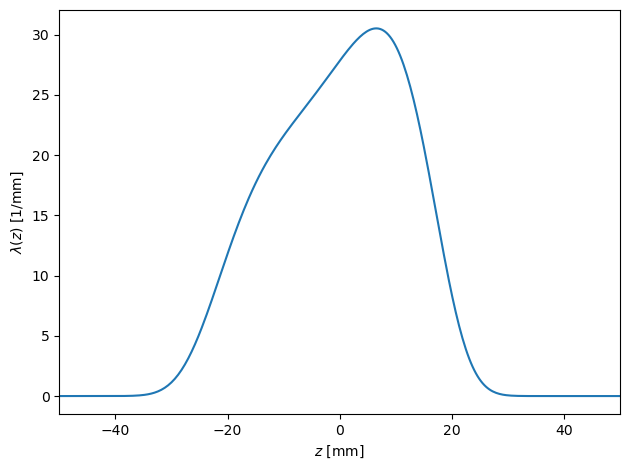

In [19]:
print_results(longeq)

# Non-uniform Filling Patterns

In [20]:
fill = 1 - 0.9*np.sin(2*np.pi*np.arange(ring.harm_num)/ring.harm_num)
fill[500:600] = 0
fill *= ring.total_current / fill.sum()
longeq = calculate_longitudinal_equilibrium(ring, [mcav, hcav, generic], fill=fill)

Calculating Longitudinal Equilibrium...
Iter.: 001, Dist. Diff.: 1.814e+00 (bucket 019), E.T.: 0.378s
--------------------
Iter.: 002, Dist. Diff.: 1.828e+00 (bucket 019), E.T.: 0.387s
--------------------
Iter.: 003, Dist. Diff.: 1.699e+00 (bucket 018), E.T.: 0.394s
--------------------
Iter.: 004, Dist. Diff.: 1.315e+00 (bucket 124), E.T.: 0.393s
--------------------
Iter.: 005, Dist. Diff.: 8.328e-01 (bucket 128), E.T.: 0.393s
--------------------
Iter.: 006, Dist. Diff.: 9.007e-01 (bucket 131), E.T.: 0.392s
--------------------
Iter.: 007, Dist. Diff.: 3.715e-01 (bucket 121), E.T.: 0.392s
--------------------
Iter.: 008, Dist. Diff.: 2.019e-01 (bucket 606), E.T.: 0.392s
--------------------
Iter.: 009, Dist. Diff.: 1.940e-01 (bucket 609), E.T.: 0.396s
--------------------
Iter.: 010, Dist. Diff.: 8.896e-02 (bucket 171), E.T.: 0.398s
--------------------
Iter.: 011, Dist. Diff.: 7.399e-02 (bucket 165), E.T.: 0.400s
--------------------
Iter.: 012, Dist. Diff.: 5.002e-02 (bucket 151)

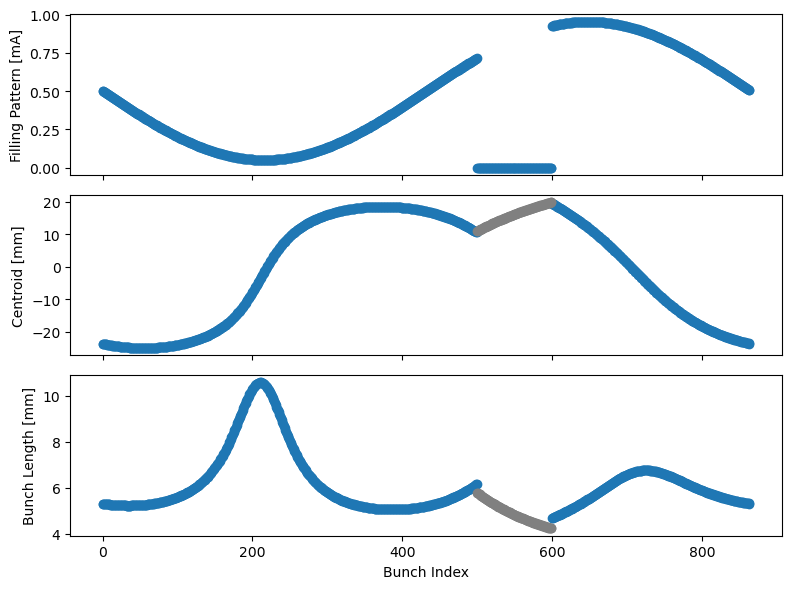

In [21]:
print_results(longeq, uniform=False)